In [53]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt

In [54]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [55]:
data_dir = 'Synthetix2'
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [56]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [57]:
data = tf.keras.utils.image_dataset_from_directory('Synthetix2')
data

Found 1561 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
import numpy as np

In [59]:
data_iterator = data.as_numpy_iterator()
data_iterator

49
49
49
49


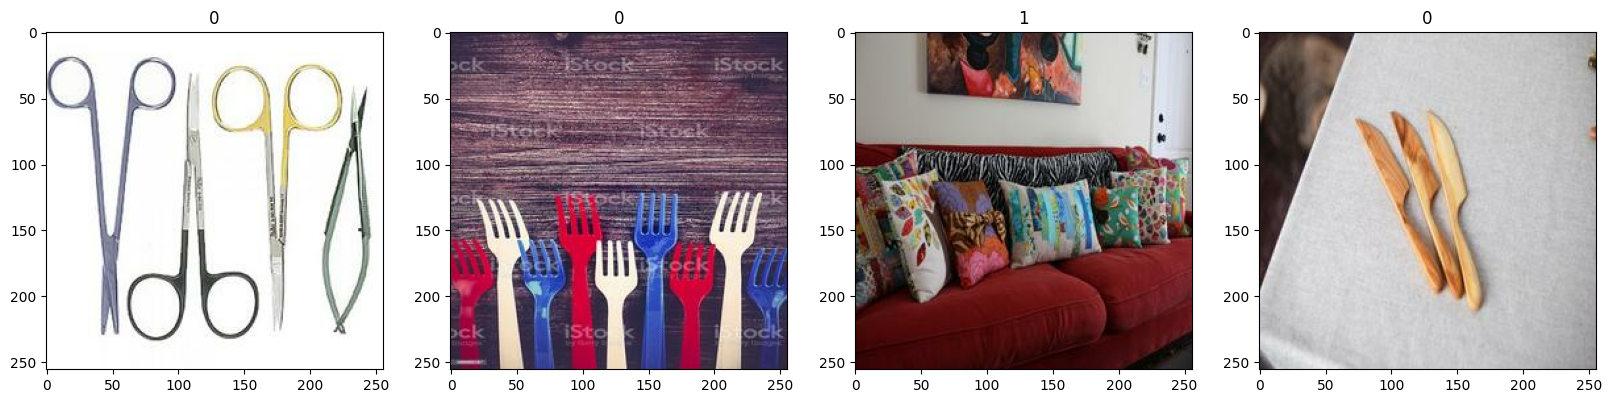

In [60]:
data = data.map(lambda x,y: (x/255, y))
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

    print(len(data))

In [61]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1
train_size,val_size,test_size

(34, 10, 5)

In [62]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [63]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [64]:
model = Sequential()

In [65]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #16 filters, 3x3 convolution
model.add(MaxPooling2D()) #compresses size


model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())


model.add(Dense(256, activation='relu')) #fully connected layer
model.add(Dense(1, activation='sigmoid')) #1 output, 0 for harmful and 1 for harmless

In [66]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [68]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
34/34 [==============================] - 19s 527ms/step - loss: 0.6797 - accuracy: 0.6195 - val_loss: 0.5455 - val_accuracy: 0.7188
Epoch 2/20
34/34 [==============================] - 17s 490ms/step - loss: 0.5005 - accuracy: 0.7546 - val_loss: 0.5182 - val_accuracy: 0.7344
Epoch 3/20
34/34 [==============================] - 17s 488ms/step - loss: 0.4596 - accuracy: 0.7730 - val_loss: 0.4673 - val_accuracy: 0.7719
Epoch 4/20
34/34 [==============================] - 16s 452ms/step - loss: 0.4652 - accuracy: 0.7849 - val_loss: 0.4982 - val_accuracy: 0.7531
Epoch 5/20
34/34 [==============================] - 15s 433ms/step - loss: 0.4151 - accuracy: 0.8042 - val_loss: 0.4126 - val_accuracy: 0.8344
Epoch 6/20
34/34 [==============================] - 15s 426ms/step - loss: 0.3754 - accuracy: 0.8217 - val_loss: 0.4840 - val_accuracy: 0.7688
Epoch 7/20
34/34 [==============================] - 14s 420ms/step - loss: 0.3025 - accuracy: 0.8594 - val_loss: 0.3699 - val_accuracy: 0.8469

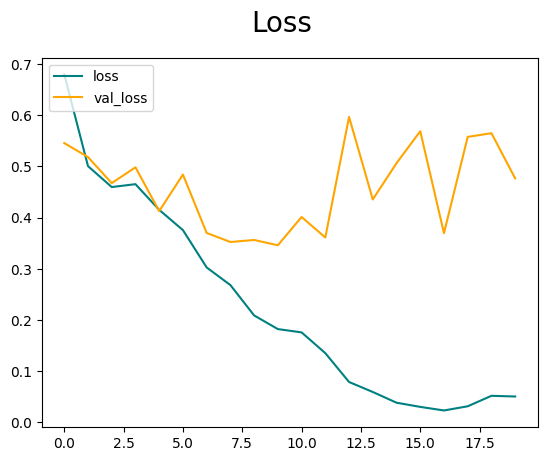

In [70]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

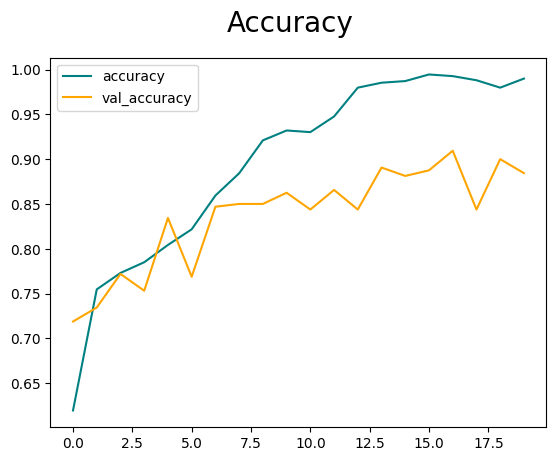

In [71]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [72]:
from keras.metrics import Precision, Recall, BinaryAccuracy


In [73]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [74]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 138ms/step


In [75]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.872093, shape=(), dtype=float32) tf.Tensor(0.9493671, shape=(), dtype=float32) tf.Tensor(0.9019608, shape=(), dtype=float32)


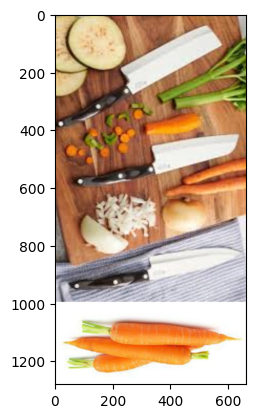

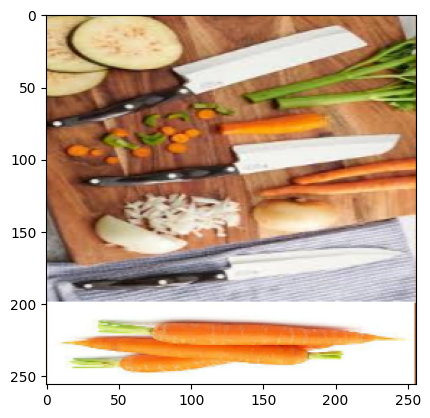

In [84]:
img = cv2.imread("Synthetix2/test/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [85]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 27ms/step


In [89]:
if yhat > 0.5: 
    print(f'Predicted class is Harmless')
else:
    print(f'Predicted class is Harmful')

Predicted class is Harmful


In [ ]:
from keras.models import load_model